# Example usage DomainAdaptFTIR

An implementation of DomainAdaptFTIR is provided in the DomainAdaptFTIR.py file and as a python package (pip install DomainAdaptFTIR). This Jupyter Notebook provides a basic demonstration of how this DomainAdaptFTIR implementation can be used. The usage is demonstrated on blood-based infrared (IR) spectral measurements, as performed in our study [cite study].

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import DomainAdaptFTIR
from DomainAdaptFTIR import DomainAdaptFTIR
from DomainAdaptFTIR import split_calibration_set

# Import data

This example uses blood-based IR absorption spectra of different individuals. The training set was measured in Garching (Germany) whereas the test set was measured in Szeged (Hungary). The calibration set consists of measurements of held out individuals with two to three visits which were measured on both sites. In general the number of visits per individual must be larger than one.

### <font color='red'>IMPORTANT NOTE:</font> The outputs of this notebook are computed with real data and real clinical information. However, the dummy data in the directory named 'data' contains simulated data with randomly assigned covariates. Therefore, the classification won't work when running the notebook yourself with the spectra in the data directory!

In [3]:
# read dataset to augment
df_train_garching = pd.read_csv('data/train_dataset_garching_individual_prediction.csv', index_col=0)

# szeged data for comparison
df_train_szeged = pd.read_csv('data/train_dataset_szeged_individual_prediction.csv', index_col=0)

# read calibration set
calibration_target = pd.read_csv('data/calibration_dataset_garching.csv', index_col=0)
calibration_source = pd.read_csv('data/calibration_dataset_szeged.csv', index_col=0)
calibration_set = pd.concat([calibration_target, calibration_source])
calibration_set = calibration_set.drop(columns=['site', 'sample_id', 'visit', 'sex'])

# define columns of wavenumbers of the dataframe
features = df_train_garching.columns[:-5].values

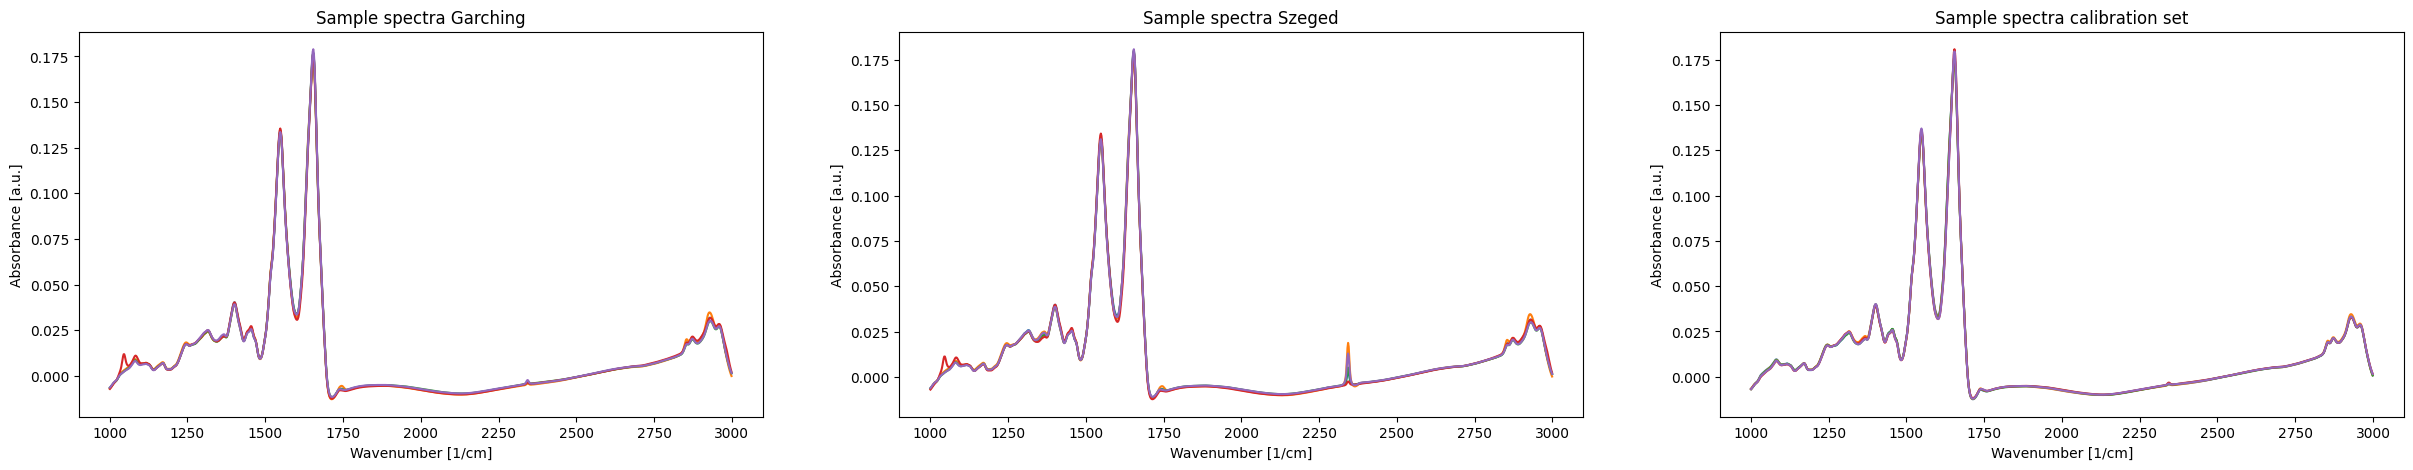

In [4]:
# plot sample spectra

plt.figure(figsize=(30, 5))

# sample spectra garching
plt.subplot(1,3,1)
plt.plot(np.array(features, dtype=float), df_train_garching[features].values[:5].T)
plt.xlabel('Wavenumber [1/cm]')
plt.ylabel('Absorbance [a.u.]')
plt.title("Sample spectra Garching")

# sample spectra szeged
plt.subplot(1,3,2)
plt.plot(np.array(features, dtype=float), df_train_szeged[features].values[:5].T)
plt.xlabel('Wavenumber [1/cm]')
plt.ylabel('Absorbance [a.u.]')
plt.title("Sample spectra Szeged")

# csample spectra calibration
plt.subplot(1,3,3)
plt.plot(np.array(features, dtype=float), calibration_set[features].values[:5].T)
plt.xlabel('Wavenumber [1/cm]')
plt.ylabel('Absorbance [a.u.]')
plt.title("Sample spectra calibration set")

plt.show()

# Augment dataset using DomainAdaptFTIR

In [5]:
# initialize DomainAdaptFTIR
dapter = DomainAdaptFTIR(spectra=df_train_garching[features].values,
              subject_ids=df_train_garching['subject_id'].values,
              calibration_set=calibration_set[features].values,
              calibration_ids=calibration_set['subject_id'].values,
              other_labels=df_train_garching[['site', 'sample_id', 'visit', 'sex']].values,
              seed = 0)

Run DomainAdaptFTIR to fit and sample from a Multivariate Gaussian which utulizes the elemnt wise averaged covariance matrix of the calibration set:
\begin{align}
    \mathcal{G}(x|\overline{p}_i,\overline{\Sigma}_{\text{cal}}) = \frac{1}{(2\pi)^{W/2}|\overline{\Sigma}_{\text{cal}}|^{1/2}} \exp\left(-\frac{1}{2}(x-\overline{p}_i)^T \overline{\Sigma}_{\text{cal}} ^{-1} (x-\overline{p}_i)\right),
\end{align}

\begin{align}
        [\overline{\Sigma}_{\text{cal}}]_{mn}\vcentcolon=\frac{1}{H} \sum_{i=1}^{H} [\Sigma(p_i)]_{mn} \hspace{5mm} \forall m,n\in\{1,...,W\},
\end{align}

where W stands for the number of grid points on which the spectrum was measured and H denotes the number of study participants in the calibration set. In our study W=1037 and H=17. $p_i$ is the matrix containing measurements as its rows.

In [6]:
# Augment dataset
aug_spectra, aug_ids = dapter.run(n_to_generate_per_id=100, return_type='augmentation', shuffle_output=True)

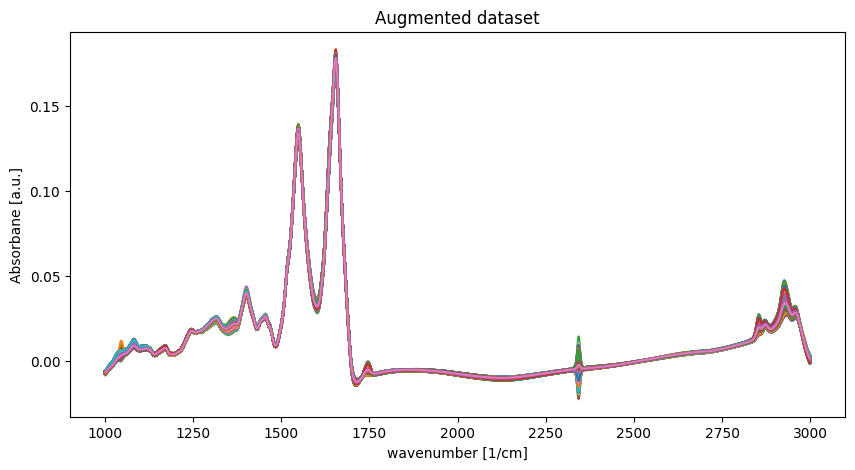

In [7]:
# Plot augmented spectra
plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
plt.plot(np.array(features, dtype=float), aug_spectra.T)
plt.xlabel('wavenumber [1/cm]')
plt.ylabel('Absorbane [a.u.]')
plt.title('Augmented dataset')
plt.show()

# Cross device prediction

In [8]:
# read test dataset
df_test_szeged = pd.read_csv('data/test_dataset_szeged_individual_prediction.csv', index_col=0)
#df_test_szeged = df_test_szeged.drop(columns=['site', 'sample_id', 'visit', 'sex'])

Our preprocessing consists of three steps:
1. Cut wavenumbers < 1000 1/cm and > 3000 1/cm: Has been conducted prior to this notebook
2. Normalization: Has been conducted prior to this notebook
3. Cut silent region: Cut wavenumbers from 1750 1/cm to 3000 1/cm

In [9]:
# cut silent region:
cols_to_use = [col for col in df_test_szeged.columns[:-5] if (1000 <= float(col) <= 1750) or (2800 <= float(col) <= 3000)]

# preprocess test data
df_test_szeged = df_test_szeged[cols_to_use + ['subject_id','site', 'sample_id', 'visit', 'sex']]

# preprocess train data
df_aug_spectra = pd.DataFrame(aug_spectra, columns=features)
df_aug_spectra = df_aug_spectra[cols_to_use]
df_aug_spectra[['subject_id','site', 'sample_id', 'visit', 'sex']] = aug_ids
display(df_aug_spectra.iloc[:, :-5])

,1000.88098144531,1002.80944824219,1004.73791503906,1006.66638183594,1008.59484863281,1010.52337646484,1012.45184326172,1014.38031005859,1016.30877685547,1018.23724365234,...,2981.4296875,2983.35815429687,2985.28662109375,2987.21508789063,2989.1435546875,2991.07202148438,2993.00048828125,2994.92895507812,2996.857421875,2998.78588867188
0,-0.006377,-0.006010,-0.005556,-0.005055,-0.004543,-0.004057,-0.003621,-0.003239,-0.002911,-0.002603,...,0.012491,0.010984,0.009533,0.008144,0.006817,0.005559,0.004389,0.003324,0.002367,0.001511
1,-0.006685,-0.006354,-0.005962,-0.005521,-0.005060,-0.004593,-0.004165,-0.003818,-0.003528,-0.003268,...,0.011411,0.009996,0.008636,0.007327,0.006077,0.004887,0.003770,0.002747,0.001819,0.000992
2,-0.006597,-0.006228,-0.005767,-0.005251,-0.004740,-0.004264,-0.003834,-0.003466,-0.003143,-0.002822,...,0.011928,0.010444,0.008996,0.007583,0.006222,0.004937,0.003745,0.002652,0.001660,0.000777
3,-0.006582,-0.006232,-0.005781,-0.005274,-0.004766,-0.004290,-0.003862,-0.003496,-0.003179,-0.002871,...,0.012319,0.010877,0.009459,0.008060,0.006699,0.005412,0.004217,0.003118,0.002120,0.001236
4,-0.006411,-0.006048,-0.005612,-0.005125,-0.004628,-0.004153,-0.003723,-0.003357,-0.003036,-0.002729,...,0.011797,0.010393,0.009016,0.007675,0.006383,0.005158,0.004011,0.002953,0.001996,0.001148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,-0.006730,-0.006392,-0.005943,-0.005436,-0.004917,-0.004435,-0.004027,-0.003691,-0.003408,-0.003130,...,0.010804,0.009286,0.007841,0.006467,0.005165,0.003949,0.002822,0.001782,0.000836,-0.000009
8133,-0.007382,-0.006982,-0.006490,-0.005952,-0.005413,-0.004908,-0.004469,-0.004098,-0.003778,-0.003476,...,0.010309,0.008657,0.007100,0.005632,0.004247,0.002955,0.001768,0.000693,-0.000253,-0.001064
8134,-0.006727,-0.006344,-0.005891,-0.005399,-0.004890,-0.004388,-0.003927,-0.003541,-0.003221,-0.002910,...,0.012409,0.010880,0.009385,0.007930,0.006530,0.005211,0.003985,0.002862,0.001858,0.000981
8135,-0.006362,-0.006018,-0.005608,-0.005156,-0.004701,-0.004266,-0.003882,-0.003561,-0.003288,-0.003040,...,0.012105,0.010698,0.009352,0.008063,0.006841,0.005686,0.004610,0.003626,0.002734,0.001935


## Individual prediction

The test set consists of the held out fourth visits of all individuals measured in Szeged.

In [10]:
# import dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [11]:
# define model and training function
def train_model(X_train, y_train):
    
    best_params = { 'C':  10,
                    'penalty': 'l2',
                    'solver': 'liblinear' }
    model = LogisticRegression(**best_params)
    model.fit(X_train, y_train)

    return model

In [12]:
# Train Model
scaler = StandardScaler()
scaled_aug_spectra = scaler.fit_transform(df_aug_spectra.iloc[:,:-5].values)
model = train_model(scaled_aug_spectra, df_aug_spectra['subject_id'].values)

# Test Model
scaled_szeged_spectra = scaler.transform(df_test_szeged.iloc[:,:-5].values)
score = model.score(scaled_szeged_spectra, df_test_szeged['subject_id'].values)
print(f'The accuracy for predicting individuals when training on augmented garching spectra and testing on szeged spectra is {np.round(score,4)*100}%')

The accuracy for predicting individuals when training on augmented garching spectra and testing on szeged spectra is 87.33999999999999%


# Plot covariance matrices

In [13]:
# Use DomainAdaptFTIR functions to calculate WPC for each site and for the calibration set
garching_reshaped, _ = dapter.reshape_data(df_train_garching[features].values, df_train_garching['subject_id'].values)
wpc_garching = dapter.get_sigma_bar(garching_reshaped)

szeged_reshaped, _ = dapter.reshape_data(df_train_szeged[features].values, df_train_szeged['subject_id'].values)
wpc_szeged = dapter.get_sigma_bar(szeged_reshaped)

cal_reshaped, _ = dapter.reshape_data(calibration_set[features].values, calibration_set['subject_id'].values)
wpc_cal = dapter.get_sigma_bar(cal_reshaped)

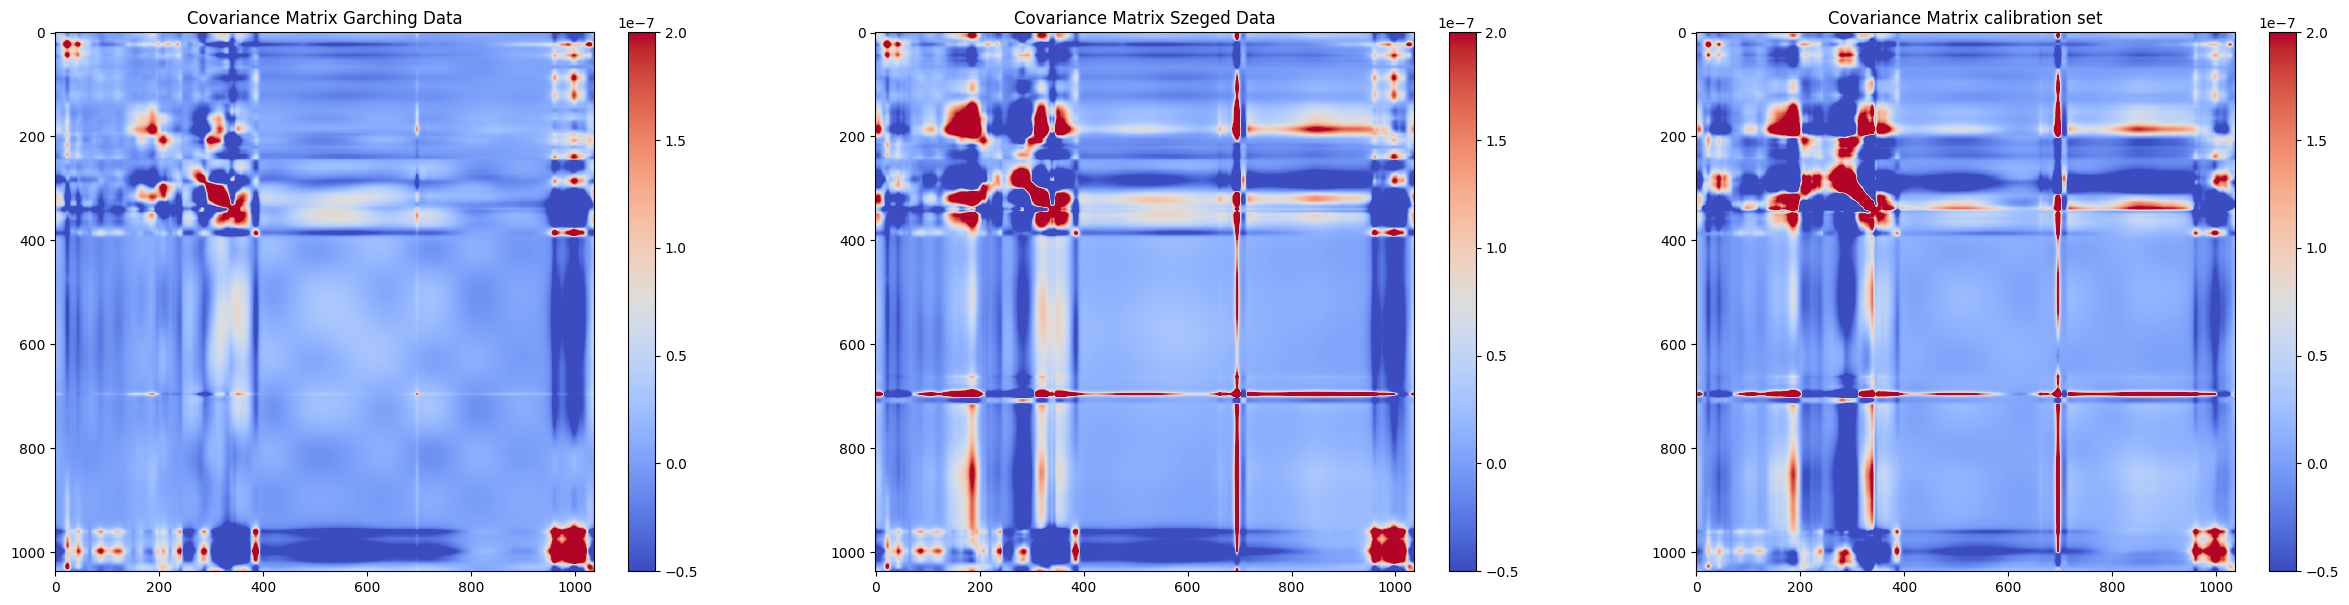

In [14]:
# plot covariance matrices
kwargs = {'cmap':'coolwarm', 'interpolation':'none', 'vmin':-0.5e-7, 'vmax':2e-7}

plt.figure(figsize=(30, 7))

# covariance matrix garching
plt.subplot(1,3,1)
plt.imshow(wpc_garching, **kwargs)
plt.colorbar()
plt.title("Covariance Matrix Garching Data")

# covariance matrix szeged
plt.subplot(1,3,2)
plt.imshow(wpc_szeged, **kwargs)
plt.colorbar()
plt.title("Covariance Matrix Szeged Data")

# covariance matrix calibration
plt.subplot(1,3,3)
plt.imshow(wpc_cal, **kwargs)
plt.colorbar()
plt.title("Covariance Matrix calibration set")

plt.show()

DomainAdaptFTIR uses the element wise averaged covariance matrix over each individual in the calibration set to generate new individuals.

# Example usage for splitting off a calibration set

In [15]:
from DomainAdaptFTIR import split_calibration_set

In [16]:
# mix measurements of both sites
# site id as a column already in both dataframes
df_train_combined = pd.concat([df_train_garching, df_train_szeged])

In [17]:
(new_calibration_set, new_calibration_ids, _), (remaining_spectra, remaining_subject_ids, _) = split_calibration_set(spectra = df_train_combined[features].values, 
                                                                                                                     subject_ids = df_train_combined['subject_id'].values, 
                                                                                                                     device_ids = df_train_combined['site'].values, 
                                                                                                                     calibration_split = 0.2, 
                                                                                                                     seed=0)

In [18]:
# make a pd.Dataframe out of the newly created dataset
new_calibration_set = pd.DataFrame(new_calibration_set, columns=features)
new_calibration_set['subject_id'] = new_calibration_ids
new_calibration_set.sort_values(by='subject_id', inplace=True)

# show the first 15 spectra of the calibration set
display(new_calibration_set.iloc[:15, :-1])

# print information about new training and calibration set
print(f'The calibration set has {len(new_calibration_set)} spectra with {len(list(set(new_calibration_ids)))} subjects in it')
print(f'The training set has {len(remaining_spectra)} spectra with {len(list(set(remaining_subject_ids)))} subjects in it')

,1000.88098144531,1002.80944824219,1004.73791503906,1006.66638183594,1008.59484863281,1010.52337646484,1012.45184326172,1014.38031005859,1016.30877685547,1018.23724365234,...,2981.4296875,2983.35815429687,2985.28662109375,2987.21508789063,2989.1435546875,2991.07202148438,2993.00048828125,2994.92895507812,2996.857421875,2998.78588867188
1,-0.006569,-0.006220,-0.005795,-0.005331,-0.004874,-0.004445,-0.004048,-0.003694,-0.003380,-0.003085,...,0.011790,0.010348,0.008950,0.007601,0.006309,0.005086,0.003948,0.002899,0.001949,0.001112
81,-0.006473,-0.006124,-0.005688,-0.005190,-0.004687,-0.004212,-0.003789,-0.003444,-0.003156,-0.002873,...,0.011846,0.010403,0.009010,0.007674,0.006402,0.005199,0.004074,0.003039,0.002109,0.001288
36,-0.006750,-0.006408,-0.005973,-0.005491,-0.004992,-0.004518,-0.004106,-0.003754,-0.003445,-0.003145,...,0.011822,0.010353,0.008941,0.007584,0.006285,0.005054,0.003907,0.002859,0.001919,0.001081
38,-0.006704,-0.006358,-0.005907,-0.005416,-0.004937,-0.004485,-0.004073,-0.003697,-0.003360,-0.003052,...,0.011605,0.010145,0.008730,0.007366,0.006053,0.004812,0.003666,0.002614,0.001660,0.000807
83,-0.006577,-0.006217,-0.005773,-0.005270,-0.004756,-0.004270,-0.003852,-0.003510,-0.003221,-0.002948,...,0.011589,0.010142,0.008741,0.007393,0.006101,0.004881,0.003748,0.002703,0.001757,0.000921
46,-0.006325,-0.005962,-0.005518,-0.005034,-0.004556,-0.004102,-0.003700,-0.003369,-0.003088,-0.002819,...,0.011783,0.010374,0.009005,0.007684,0.006423,0.005234,0.004125,0.003100,0.002173,0.001354
50,-0.006377,-0.005970,-0.005481,-0.004952,-0.004425,-0.003936,-0.003520,-0.003179,-0.002903,-0.002661,...,0.011621,0.010154,0.008744,0.007387,0.006091,0.004872,0.003740,0.002709,0.001787,0.000979
26,-0.006854,-0.006482,-0.006011,-0.005514,-0.005021,-0.004543,-0.004118,-0.003758,-0.003453,-0.003170,...,0.011562,0.010062,0.008614,0.007223,0.005895,0.004647,0.003487,0.002425,0.001478,0.000648
20,-0.006557,-0.006235,-0.005815,-0.005334,-0.004836,-0.004362,-0.003949,-0.003597,-0.003282,-0.002990,...,0.011931,0.010516,0.009147,0.007825,0.006559,0.005360,0.004241,0.003218,0.002302,0.001491
65,-0.006412,-0.006037,-0.005597,-0.005119,-0.004622,-0.004156,-0.003756,-0.003424,-0.003154,-0.002900,...,0.011938,0.010536,0.009185,0.007879,0.006627,0.005447,0.004343,0.003327,0.002413,0.001605


The calibration set has 90 spectra with 15 subjects in it
The training set has 384 spectra with 64 subjects in it
